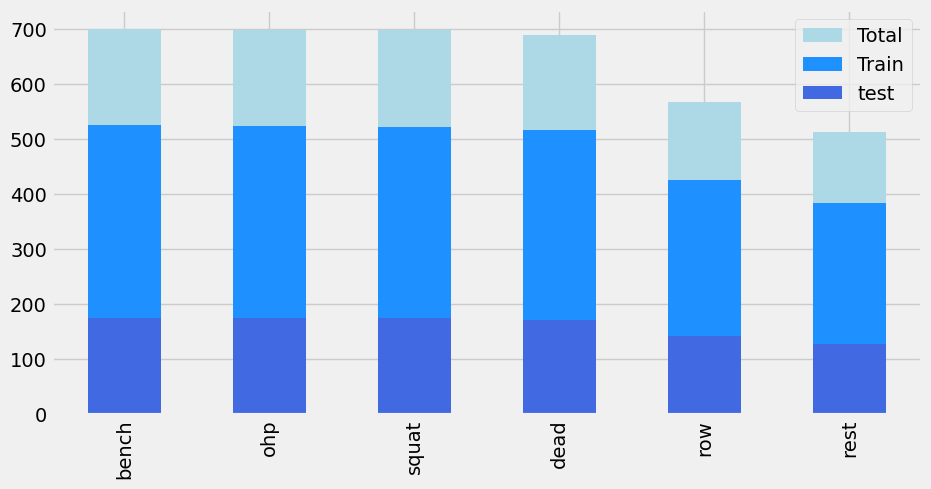

Basic features: 6
Square features: 2
PCA features: 3
Time features: 16
Frequency features: 80
Cluster features: 1
0
1
2
3


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from LearningAlgorithms import ClassificationAlgorithms
import seaborn as sns
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score


# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

df = pd.read_pickle("/Users/rishanthreddy/Desktop/Tracking barbell Exercises/data/interim/03_data_features.pkl")
# --------------------------------------------------------------
# Create a training and test set
# --------------------------------------------------------------
df_train = df.drop(["participant","category","set"],axis=1)

X = df_train.drop("label",axis = 1)
y = df_train["label"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

fig,ax = plt.subplots(figsize=(10,5))
df_train["label"].value_counts().plot(
    
    kind="bar",ax=ax,color="lightblue",label="Total"
)

y_train.value_counts().plot(kind="bar",ax=ax,color="dodgerblue",label="Train")
y_test.value_counts().plot(kind="bar",ax=ax,color="royalblue",label="test")

plt.legend()
plt.show()

# --------------------------------------------------------------
# Split feature subsets
# --------------------------------------------------------------
basic_features = ["acc_x","acc_y","acc_z","gyr_x","gyr_y","gyr_z"]
square_features = ["acc_x","gyr_r"]
pca_features = ["pca_1","pca_2","pca_3"]
time_features = [f for f in df_train.columns if "_temp_" in f]
freq_features = [f for f in df_train.columns if (("_freq_" in f) or ("_pse" in f))]
cluster_features = ["cluster"]

print("Basic features:", len(basic_features))

print("Square features:", len(square_features))

print("PCA features:", len(pca_features))

print("Time features:", len(time_features))

print("Frequency features:", len(freq_features))

print("Cluster features:", len(cluster_features))

feature_set_1 = list(set(basic_features))

feature_set_2 = list(set(basic_features + square_features + pca_features))

feature_set_3 = list(set(feature_set_2 + time_features))

feature_set_4 = list(set(feature_set_3 + freq_features + cluster_features))


# --------------------------------------------------------------
# Perform forward feature selection using simple decision tree
# --------------------------------------------------------------
learner = ClassificationAlgorithms()

max_features = 10

selected_features,ordered_features,ordered_scores = learner.forward_selection(max_features,X_train,y_train)

 
#selected_features = ['pca_1', 'duration', 'acc_z_freq_0.0_Hz_ws_14', 'acc_y_temp_mean_ws_5', 'gyr_x_freq_1.071_Hz_ws_14', 'cluster', 'acc_z_temp_std_ws_5', 'gyr_x_freq_1.429_Hz_ws_14', 'gyr_y', 'acc_r_freq_2.5_Hz_ws_14']
selected_features = ['pca_1', 'duration', 'acc_z_freq_0.0_Hz_ws_14', 'acc_y_temp_mean_ws_5', 'gyr_x_freq_1.071_Hz_ws_14', 'gyr_y_freq_0.714_Hz_ws_14', 'acc_x_max_freq', 'acc_x_freq_2.5_Hz_ws_14', 'gyr_r_freq_2.143_Hz_ws_14', 'acc_y_max_freq']


plt.figure(figsize = (10,5))
plt.plot(np.arange(1,max_features + 1,1),ordered_scores)
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1,max_features + 1,1))
plt.show()
# --------------------------------------------------------------
# Grid search for best hyperparameters and model selection
# --------------------------------------------------------------
possible_feature_sets = [
   
    feature_set_4,
   
]



feature_names = [
    
    "feature_set_4",
   
]



iterations = 1
score_df = pd.DataFrame()


for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=True,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)

        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
           
            
        }
    )
    score_df = pd.concat([score_df, new_scores])


# --------------------------------------------------------------
# Create a grouped bar plot to compare the results
# --------------------------------------------------------------
score_df.sort_values(by = "accuracy",ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x="model",y="accuracy",hue="feature_set",data=score_df)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.7,1)
plt.legend(loc="lower right")
plt.show()




# --------------------------------------------------------------
# Select best model and evaluate results
# --------------------------------------------------------------
(
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
                X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=True,print_model_details=True
)
accuracy = accuracy_score(y_test, class_test_y)
print(accuracy)
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test,class_test_y,labels = classes)


precision = precision_score(y_test, class_test_y, average='macro')
recall = recall_score(y_test, class_test_y, average='macro')
f1 = f1_score(y_test, class_test_y, average='macro')









# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()


# --------------------------------------------------------------
# Select train and test data based on participant
# --------------------------------------------------------------
participant_df = df.drop(["set", "category"], axis=1)

X_train = participant_df[participant_df ["participant"] != "A"].drop("label", axis=1)

y_train = participant_df[participant_df["participant"] != "A"]["label"]

X_test = participant_df[participant_df["participant"] == "A"].drop("label", axis=1)

y_test = participant_df[participant_df ["participant"] == "A"]["label"]

X_train = X_train.drop(["participant"], axis=1)

X_test = X_test.drop(["participant"], axis=1)

fig, ax = plt.subplots(figsize=(10, 5))

df_train["label"].value_counts().plot(

kind="bar", ax=ax, color="lightblue", label="Total"
)

y_train.value_counts().plot(kind="bar", ax=ax, color="dodgerblue", label="Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label="Test")

plt.legend()
plt.show()

# --------------------------------------------------------------
# Use best model again and evaluate results
# --------------------------------------------------------------
(
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
                X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=True
)
accuracy = accuracy_score(y_test, class_test_y)
print(accuracy)
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test,class_test_y,labels = classes)

# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()


# --------------------------------------------------------------
# Try a simpler model with the selected features
# --------------------------------------------------------------

In [ ]:
precision = precision_score(y_test, class_test_y, average='macro')
recall = recall_score(y_test, class_test_y, average='macro')
f1 = f1_score(y_test, class_test_y, average='macro')


In [ ]:
print(precision)
print(recall)
print(f1
)

0.985897435897436
0.9959610739502044
0.9907520400294291


In [ ]:
print(precision)
print(recall)
print(f1
)

0.985897435897436
0.9959610739502044
0.9907520400294291
